# Optimizacija hiperparametrov XGB

In [1]:
%run __A_knjiznice.py

# Import specific elements from the script
from __A_knjiznice import *
from __B_funkcije import *
import __C_konstante as kon
%matplotlib inline

In [2]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load your dataset
df = pd.read_csv(f'{kon.path_files}/molekulski_prstni_odtisi/df_circular.csv')
y = df[['Activity']].values.ravel()  # Assuming 'Activity' is the target
X = df.iloc[:, 3:]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=kon.random_seed, stratify=y)

# Define cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=kon.random_seed)

# Define the Optuna optimization function
def objective(trial):
    # Define hyperparameters for XGBClassifier
    n_estimators = trial.suggest_int('n_estimators', 50, 150)  # Tuning the number of estimators
    max_depth = trial.suggest_int('max_depth', 3, 10)  # Tuning max depth
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)  # Tuning learning rate
    gamma = trial.suggest_float('gamma', 0.1, 1.0)  # Tuning gamma
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)  # Tuning min_child_weight
    subsample = trial.suggest_float('subsample', 0.5, 1.0)  # Tuning subsample
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)  # Tuning colsample_bytree
    
    # Define feature selection (SelectKBest)
    k_best = trial.suggest_int('k_best', 1, 300)  # Tuning the number of features to select
    
    # Create the pipeline with VarianceThreshold and SelectKBest
    model = Pipeline([
        ('variance_threshold', VarianceThreshold()),  # Apply VarianceThreshold to remove low-variance features
        ('select_k_best', SelectKBest(score_func=chi2, k=k_best)),  # Apply SelectKBest with chi2 scoring function
        ('xgb', XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            gamma=gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            n_jobs=-1,
            random_state=42
        ))
    ])
    
    # Cross-validation: Optimize based on mean accuracy
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    return np.mean(cv_scores)  # Return the mean of the cross-validation scores

# Create the Optuna study and optimize it
study = optuna.create_study(direction='maximize')  # We want to maximize accuracy
study.optimize(objective, n_trials=50)  # Number of trials to run (can adjust this)

# Output the best trial results
print('Best trial:')
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print(f"  Params: {best_trial.params}")

[I 2024-12-30 17:59:10,976] A new study created in memory with name: no-name-d567eaf8-daee-4b49-975e-c440f7192fe3
[I 2024-12-30 17:59:11,921] Trial 0 finished with value: 0.6933357028612049 and parameters: {'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.11249579831956484, 'gamma': 0.5765315969215109, 'min_child_weight': 4, 'subsample': 0.9323913576107992, 'colsample_bytree': 0.9648359374162254, 'k_best': 5}. Best is trial 0 with value: 0.6933357028612049.
[I 2024-12-30 17:59:13,400] Trial 1 finished with value: 0.8475714617708576 and parameters: {'n_estimators': 63, 'max_depth': 10, 'learning_rate': 0.1679216292149399, 'gamma': 0.750356606569468, 'min_child_weight': 10, 'subsample': 0.6584799100549575, 'colsample_bytree': 0.7687126271649836, 'k_best': 76}. Best is trial 1 with value: 0.8475714617708576.
[I 2024-12-30 17:59:15,166] Trial 2 finished with value: 0.8551165853280658 and parameters: {'n_estimators': 144, 'max_depth': 4, 'learning_rate': 0.09669575052319501, 'gamma'

Best trial:
  Value: 0.876247761479679
  Params: {'n_estimators': 136, 'max_depth': 10, 'learning_rate': 0.0625570116065779, 'gamma': 0.17779501644480664, 'min_child_weight': 1, 'subsample': 0.7142468392066575, 'colsample_bytree': 0.8330540568180412, 'k_best': 262}


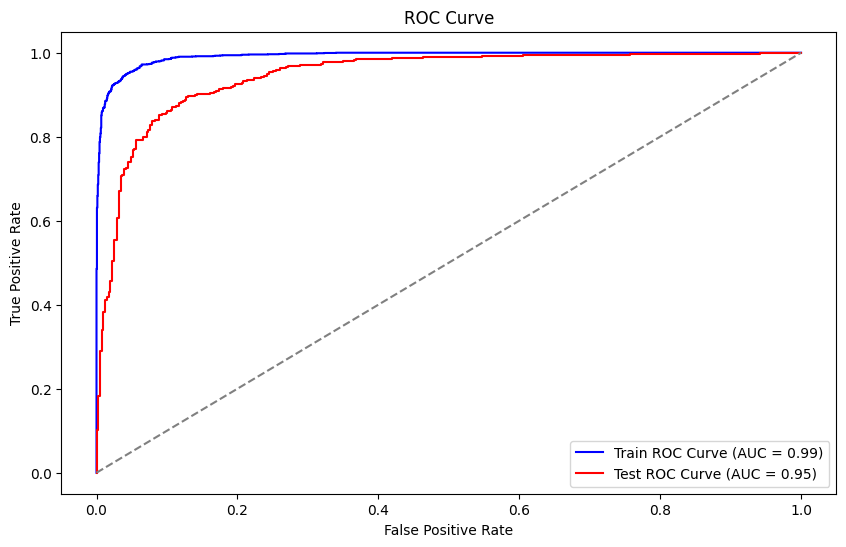

In [3]:
# Extract the best hyperparameters
best_params = best_trial.params
n_estimators = best_params['n_estimators']
max_depth = best_params['max_depth']
learning_rate = best_params['learning_rate']
gamma = best_params['gamma']
min_child_weight = best_params['min_child_weight']
subsample = best_params['subsample']
colsample_bytree = best_params['colsample_bytree']
k_best = best_params['k_best']

# Create the final pipeline with the best parameters
final_model = Pipeline([
    ('variance_threshold', VarianceThreshold()), 
    ('select_k_best', SelectKBest(score_func=chi2, k=k_best)),
    ('xgb', XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        gamma=gamma,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        n_jobs=-1,
        random_state=42
    ))
])

# Fit the model on the full training data
final_model.fit(X_train, y_train)

# Predictions for train data
y_train_pred = final_model.predict(X_train)
y_train_prob = final_model.predict_proba(X_train)[:, 1]  # Probabilities for ROC AUC

# Predictions for test data
y_test_pred = final_model.predict(X_test)
y_test_prob = final_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Calculate accuracy and AUC for train and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_auc = roc_auc_score(y_train, y_train_prob)
test_auc = roc_auc_score(y_test, y_test_prob)

# Plot ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC Curve (AUC = {train_auc:.2f})')
plt.plot(fpr_test, tpr_test, color='red', label=f'Test ROC Curve (AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

Train Accuracy: 0.9523
Test Accuracy: 0.8794
Train AUC: 0.9920
Test AUC: 0.9467


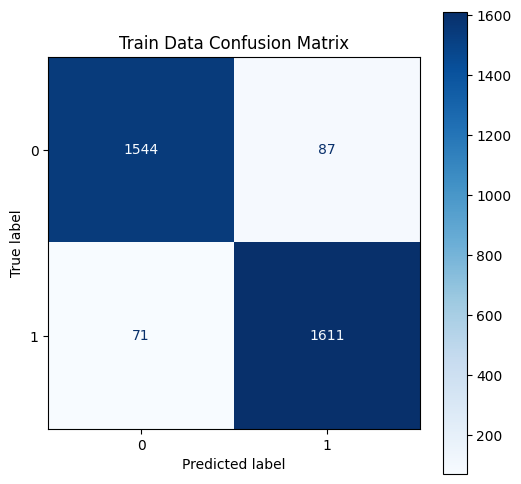

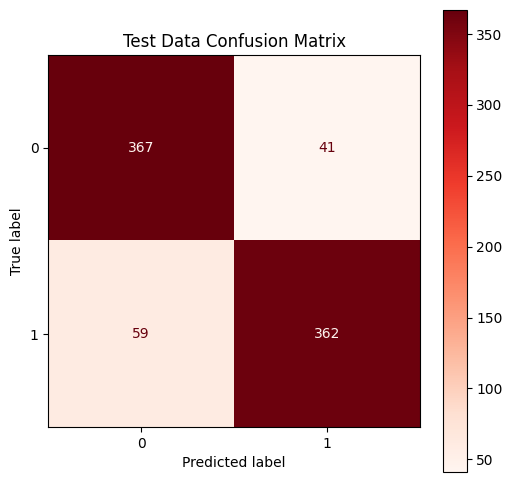

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Confusion Matrix for Train and Test
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

# Print accuracy and AUC scores
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


# Display Confusion Matrix for Train data
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(confusion_matrix=train_cm).plot(cmap='Blues', ax=ax)
ax.set_title('Train Data Confusion Matrix')
plt.show()

# Display Confusion Matrix for Test data
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(confusion_matrix=test_cm).plot(cmap='Reds', ax=ax)
ax.set_title('Test Data Confusion Matrix')
plt.show()